Train shape: (20758, 18)
Test shape : (13840, 17)

Columns in train:
['id', 'Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad']
Dropped 'id' from features.
Dropped 'id' from test features and stored as test_ids.

Numeric columns: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Categorical columns: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

Target distribution:
NObeyesdad
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: count, dtype: int64

X_train: (16606, 16)
X_val  : (4152, 16)

Categorical feature indices (CatBoost): [0, 4, 5, 8, 9, 11, 14, 15]
0:	learn: 0.6962536	test: 0.7092343	best: 0.7092343 (0)	total: 628ms	remaining: 10m 27s
100:	learn: 0.9

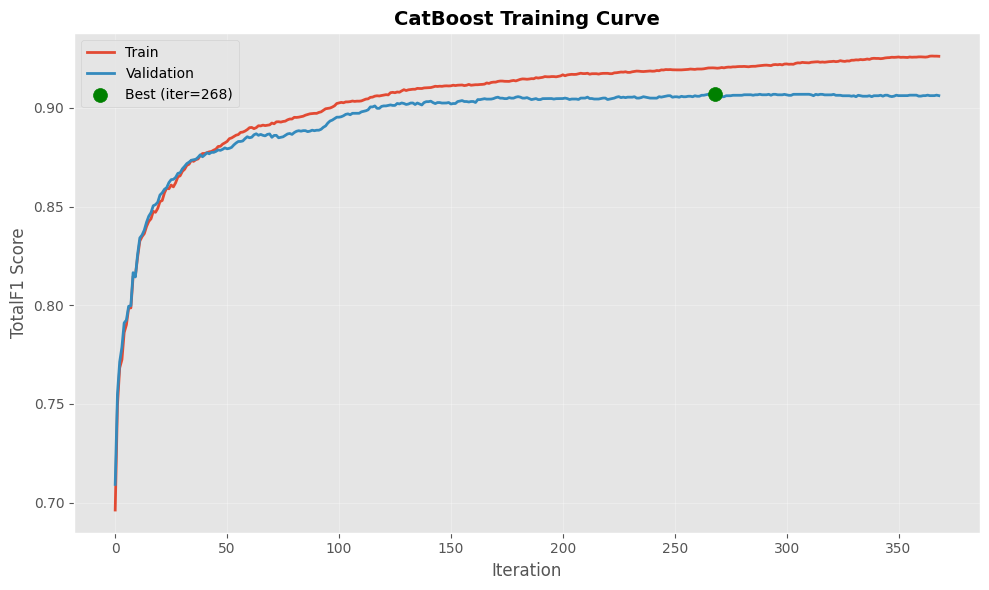


Best iteration: 268
Best validation F1: 0.9069

Validation Accuracy : 0.9073
Validation Macro-F1 : 0.8972

Classification report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.96      0.95       505
      Normal_Weight       0.90      0.88      0.89       617
     Obesity_Type_I       0.88      0.89      0.89       582
    Obesity_Type_II       0.96      0.97      0.97       650
   Obesity_Type_III       0.99      1.00      1.00       809
 Overweight_Level_I       0.81      0.76      0.79       485
Overweight_Level_II       0.80      0.82      0.81       504

           accuracy                           0.91      4152
          macro avg       0.90      0.90      0.90      4152
       weighted avg       0.91      0.91      0.91      4152



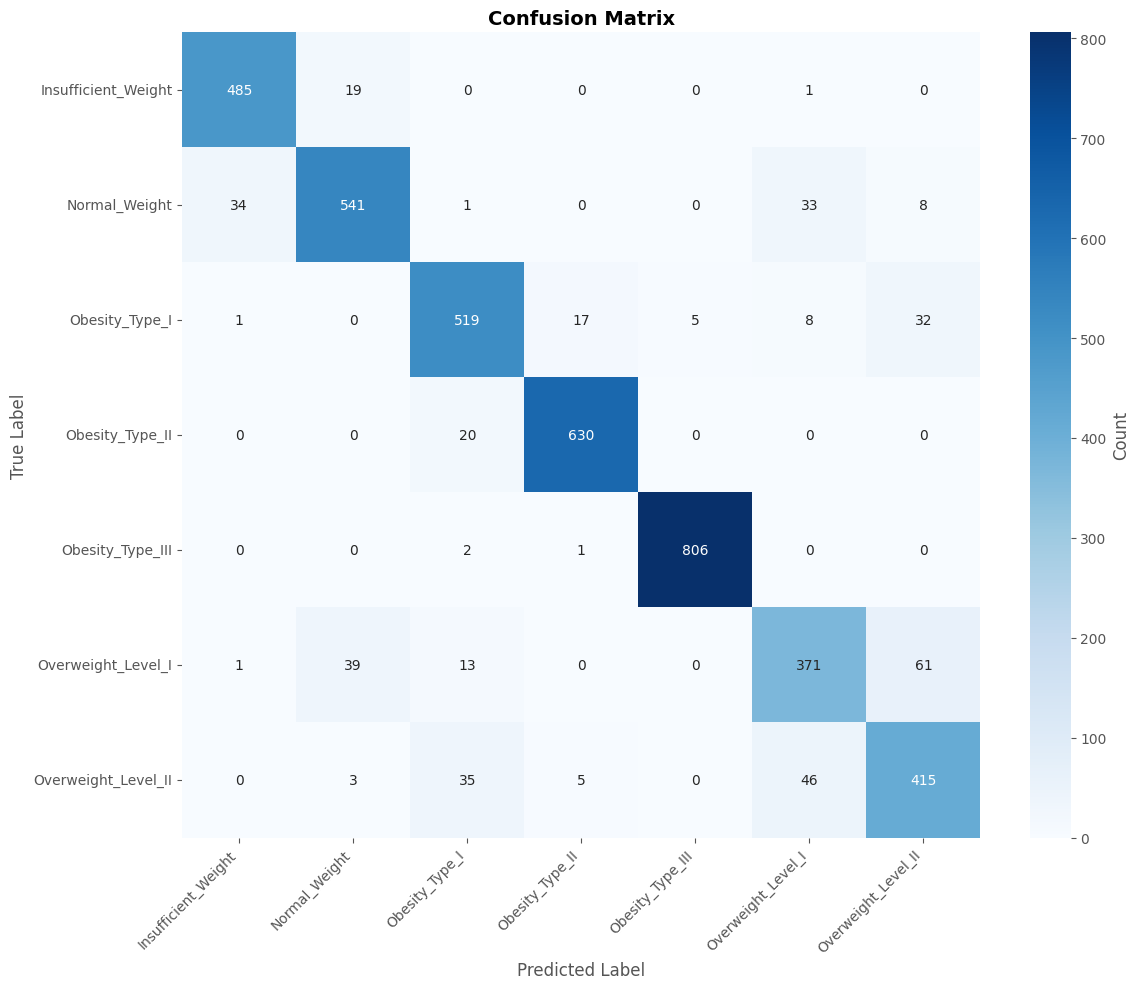

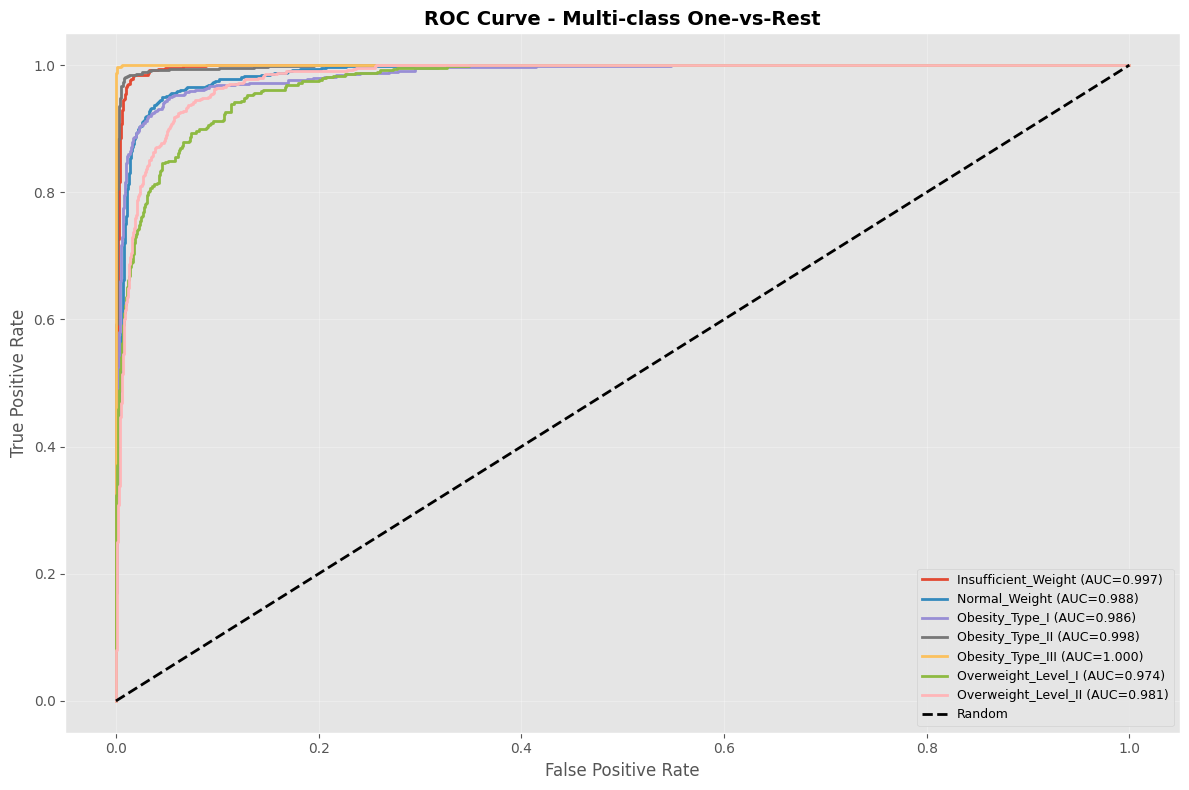


Macro AUC: 0.9892
Micro AUC: 0.9928


/tmp/ipython-input-3816675719.py:229: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df_top, x='Importance', y='Feature', palette='viridis')


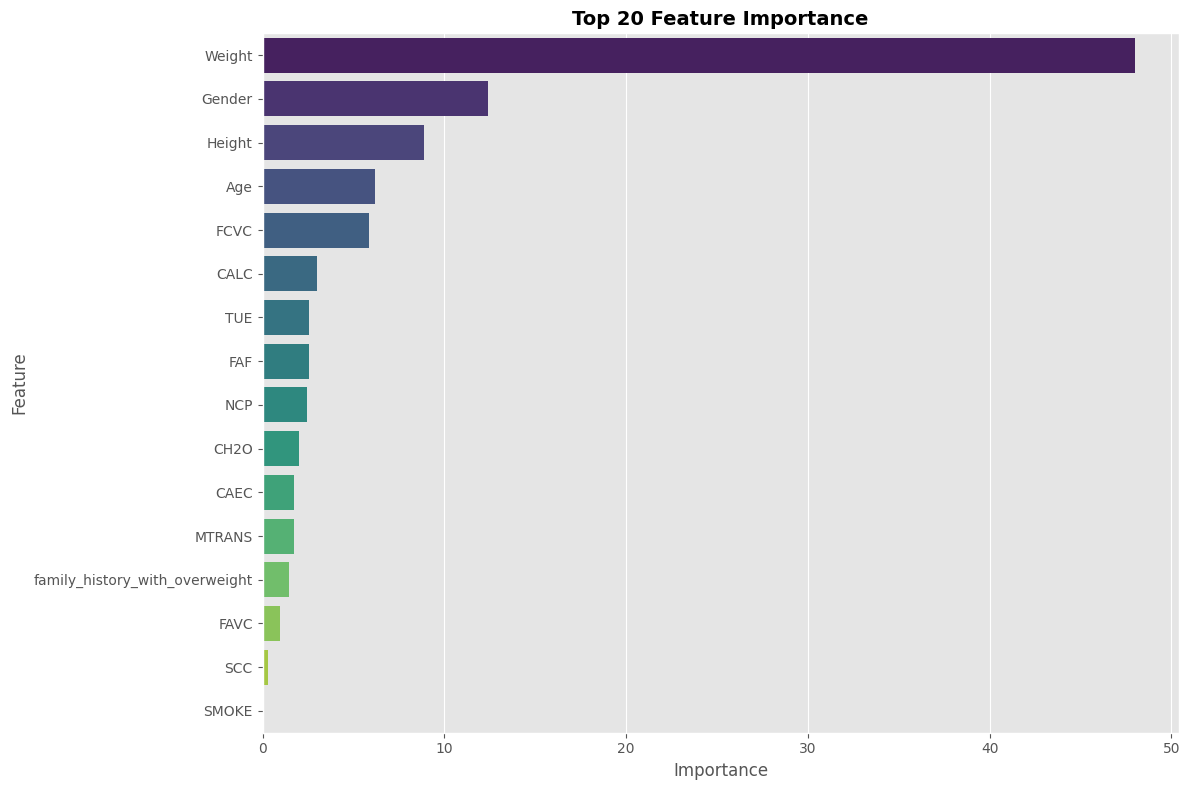


Top 20 most important features:
                       Feature  Importance
                        Weight   47.999400
                        Gender   12.395511
                        Height    8.869795
                           Age    6.176134
                          FCVC    5.879979
                          CALC    3.022863
                           TUE    2.562877
                           FAF    2.538385
                           NCP    2.424082
                          CH2O    1.983063
                          CAEC    1.755315
                        MTRANS    1.727390
family_history_with_overweight    1.430276
                          FAVC    0.940216
                           SCC    0.294714
                         SMOKE    0.000000
0:	learn: 0.7249645	total: 275ms	remaining: 1m 13s
100:	learn: 0.9034887	total: 27.9s	remaining: 46.1s


In [ ]:
# Part 1: Imports & basic setup
!pip install catboost --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize

from catboost import CatBoostClassifier, Pool

RANDOM_STATE = 42
TARGET_COL = "NObeyesdad"

plt.style.use("ggplot")
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

# Part 2: Load data
train_path = "sample_data/train.csv"
test_path = "sample_data/test.csv"
sub_path = "sample_data/sample_submission.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
sample_submission = pd.read_csv(sub_path)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)
print("\nColumns in train:")
print(train_df.columns.tolist())

# Part 3: Basic preprocessing
y = train_df[TARGET_COL]
X = train_df.drop(columns=[TARGET_COL])

if "id" in X.columns:
    X = X.drop(columns=["id"])
    print("Dropped 'id' from features.")

test_ids = None
if "id" in test_df.columns:
    test_ids = test_df["id"].copy()
    test_df = test_df.drop(columns=["id"])
    print("Dropped 'id' from test features and stored as test_ids.")

categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)
print("\nTarget distribution:")
print(y.value_counts())

# Part 4: Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("\nX_train:", X_train.shape)
print("X_val  :", X_val.shape)

cat_feature_indices = [X_train.columns.get_loc(col) for col in categorical_cols]
print("\nCategorical feature indices (CatBoost):", cat_feature_indices)

# Part 5: Create CatBoost Pools
train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_feature_indices
)

val_pool = Pool(
    data=X_val,
    label=y_val,
    cat_features=cat_feature_indices
)

# ==========================================
# Part 6: 训练模型并可视化训练曲线
# ==========================================
model = CatBoostClassifier(
    loss_function="MultiClass",
    eval_metric="TotalF1",
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3.0,
    random_seed=RANDOM_STATE,
    iterations=1000,
    early_stopping_rounds=100,
    verbose=100
)

model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True
)

# 可视化 1: 训练曲线
def plot_training_curve(model):
    """绘制训练和验证损失曲线"""
    # 获取训练历史
    evals_result = model.get_evals_result()

    # 提取训练和验证指标
    train_metric = evals_result['learn']['TotalF1']
    val_metric = evals_result['validation']['TotalF1']

    best_iter = model.get_best_iteration()
    best_score = val_metric[best_iter]

    plt.figure(figsize=(10, 6))
    plt.plot(train_metric, label='Train', linewidth=2)
    plt.plot(val_metric, label='Validation', linewidth=2)
    plt.scatter(best_iter, best_score, color='green', s=100,
                label=f'Best (iter={best_iter})', zorder=5)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('TotalF1 Score', fontsize=12)
    plt.title('CatBoost Training Curve', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\nBest iteration: {best_iter}")
    print(f"Best validation F1: {best_score:.4f}")

plot_training_curve(model)

# Part 7: Evaluation on validation set
y_val_pred = model.predict(val_pool).reshape(-1)
y_val_proba = model.predict_proba(val_pool)

val_acc = accuracy_score(y_val, y_val_pred)
val_macro_f1 = f1_score(y_val, y_val_pred, average="macro")

print(f"\nValidation Accuracy : {val_acc:.4f}")
print(f"Validation Macro-F1 : {val_macro_f1:.4f}")

print("\nClassification report:")
print(classification_report(y_val, y_val_pred))

# ==========================================
# 可视化 2: 混淆矩阵热力图
# ==========================================
def plot_confusion_matrix(y_true, y_pred, classes):
    """绘制混淆矩阵热力图"""
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_val, y_val_pred, model.classes_)

# ==========================================
# 可视化 3: ROC曲线 (多分类)
# ==========================================
def plot_roc_curves_multiclass(y_true, y_proba, classes):
    """绘制多分类ROC曲线"""
    # 将标签二值化
    y_true_bin = label_binarize(y_true, classes=classes)
    n_classes = len(classes)

    # 计算每个类别的ROC曲线
    plt.figure(figsize=(12, 8))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2,
                label=f'{classes[i]} (AUC={roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve - Multi-class One-vs-Rest', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 计算总体AUC
    macro_auc = roc_auc_score(y_true_bin, y_proba,
                              multi_class="ovr", average="macro")
    micro_auc = roc_auc_score(y_true_bin, y_proba,
                              multi_class="ovr", average="micro")

    print(f"\nMacro AUC: {macro_auc:.4f}")
    print(f"Micro AUC: {micro_auc:.4f}")

plot_roc_curves_multiclass(y_val, y_val_proba, model.classes_)

# ==========================================
# 可视化 4: 特征重要性
# ==========================================
def plot_feature_importance(model, feature_names, top_n=20):
    """绘制特征重要性图"""
    # 获取特征重要性
    feature_importance = model.get_feature_importance()

    # 创建DataFrame
    fi_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    # 只显示top_n个特征
    fi_df_top = fi_df.head(top_n)

    plt.figure(figsize=(12, 8))
    sns.barplot(data=fi_df_top, x='Importance', y='Feature', palette='viridis')
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title(f'Top {top_n} Feature Importance', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"\nTop {top_n} most important features:")
    print(fi_df_top.to_string(index=False))

    return fi_df

fi_df = plot_feature_importance(model, X_train.columns, top_n=20)

# ==========================================
# Part 8: 训练最终模型
# ==========================================
# 使用全部训练数据重新训练模型
full_pool = Pool(
    data=X,
    label=y,
    cat_features=[X.columns.get_loc(col) for col in categorical_cols]
)

best_iter = model.get_best_iteration()

final_model = CatBoostClassifier(
    loss_function="MultiClass",
    eval_metric="TotalF1",
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3.0,
    random_seed=RANDOM_STATE,
    iterations=best_iter if best_iter > 0 else 1000,
    verbose=100
)

final_model.fit(full_pool)

# 保存模型
final_model.save_model("catboost_obesity_model.cbm")
print("\nFinal CatBoost model saved to catboost_obesity_model.cbm")

# ==========================================
# Part 9: 预测测试集并生成提交文件
# ==========================================
test_pool = Pool(
    data=test_df,
    cat_features=[test_df.columns.get_loc(col) for col in categorical_cols]
)

test_preds = final_model.predict(test_pool).reshape(-1)

submission = sample_submission.copy()
submission[TARGET_COL] = test_preds

submission.to_csv("catboost_submission.csv", index=False)

print("\n" + "="*50)
print("Submission file 'catboost_submission.csv' has been created.")
print("="*50)
print("\nSubmission preview:")
print(submission.head(10))